<a href="https://colab.research.google.com/github/Agoroschuk/ML_tasks/blob/main/lab_2/asg_main_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [ ]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`.

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
```
You can use:
```
np.add(b,c,out = a) # puts result in `a`
```

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/ML_DL/ML/Lab_2/nn_from_scratch/
%ls

/content/drive/MyDrive/ML_DL/ML/Lab_2/nn_from_scratch
my_main_notebook.ipynb  my_modules.ipynb


In [ ]:
%run my_modules.ipynb

<>:3: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-3092293347.py:3: SyntaxWarning: invalid escape sequence '\g'
  Implements linear transform of input y = \gamma * x + \beta


In [ ]:
# реализованные методы
# dir()

import inspect
print(inspect.getsource(SoftMax.updateOutput))

    def updateOutput(self, input):
        """
        Т.к. softmax(z_i) = exp(z_i) / ∑exp(z_j), то высокие значения z могут
        стать слишком большими => проблемы с численным представлением и стабильностью
        Поэтому из всех z вычитается самое большое значение в строке, т.е. по всем признакам
        """
        # start with normalization for numerical stability
        # input.max(axis=1, keepdims=True) ищет максимальное значение в каждой строке
        # np.subtract вычитает этот максимум из всех элементов строки
        # (n_samples, n_classes)
        shifted = np.subtract(input, input.max(axis=1, keepdims=True))

        # Your code goes here. ################################################
        # (n_samples, n_classes)
        exp_shifted = np.exp(shifted)
        # (n_samples, n_classes)
        self.output = exp_shifted / np.sum(exp_shifted, axis=1, keepdims=True)

        return self.output



# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

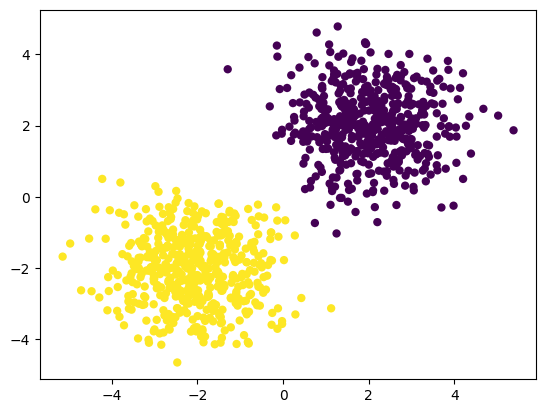

In [ ]:
# Generate some data
N = 500

# 2 массива из станд.норм.распр. N*2, каждый смещен по-своему по строкам и столбцам
X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
# the same
# Y = np.concatenate([np.ones(N),np.zeros(N)]).reshape(-1,1)
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,1], edgecolors= 'none')

Define a **logistic regression** for debugging.

In [ ]:
# net = Sequential()
# net.add(Linear(2, 2))
# net.add(LogSoftMax())

# criterion = ClassNLLCriterion()

# print(net)

# Test something like that then

net = Sequential()
net.add(Linear(2, 4))
net.add(ReLU())
net.add(Linear(4, 2))
net.add(LogSoftMax())
criterion = ClassNLLCriterion()
print(net)

Linear 2 -> 4
ReLU
Linear 4 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [ ]:
# Optimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [ ]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)

    for start in range(0, n_samples, batch_size):
        # для предотвращения выхода за границы батча
        end = min(start + batch_size, n_samples)

        batch_idx = indices[start:end]

        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

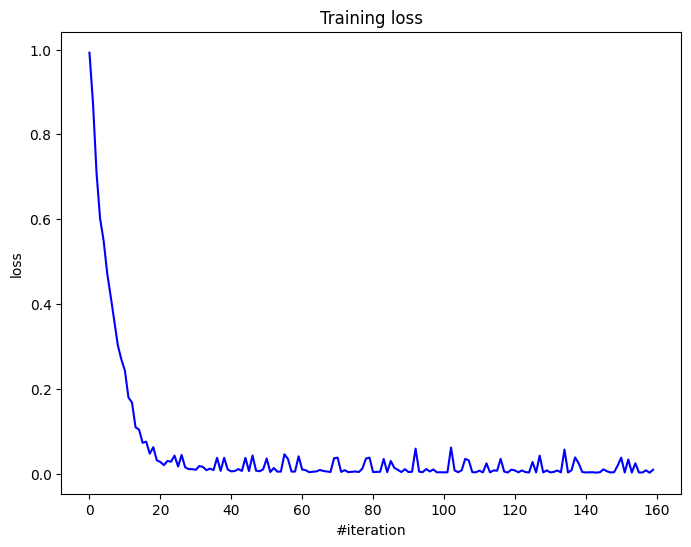

Current loss: 0.009434


In [ ]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):

        net.zeroGradParameters()

        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)

        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)

        # Update weights
        sgd_momentum(net.getParameters(),
                     net.getGradParameters(),
                     optimizer_config,
                     optimizer_state)

        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))

    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()

    print('Current loss: %f' % loss)

# Digit classification

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. It can be downloaded with the following file.

In [ ]:
!wget https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py -nc

--2025-12-08 19:01:06--  https://raw.githubusercontent.com/girafe-ai/ml-course/23f_basic/homeworks/hw08_nn_from_scratch/mnist.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2697 (2.6K) [text/plain]
Saving to: ‘mnist.py’

mnist.py            100%[===================>]   2.63K  --.-KB/s    in 0.003s  

2025-12-08 19:01:06 (935 KB/s) - ‘mnist.py’ saved [2697/2697]



In [ ]:
import keras

def load_dataset(flatten=False):
    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

    # normalize x
    X_train = X_train.astype(float) / 255.
    X_test = X_test.astype(float) / 255.

    # we reserve the last 10000 training examples for validation
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    if flatten:
        X_train = X_train.reshape([X_train.shape[0], -1])
        X_val = X_val.reshape([X_val.shape[0], -1])
        X_test = X_test.reshape([X_test.shape[0], -1])

    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
import mnist

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(type(X_train), type(y_train), type(X_val), type(y_val), type(X_test), type(y_test))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


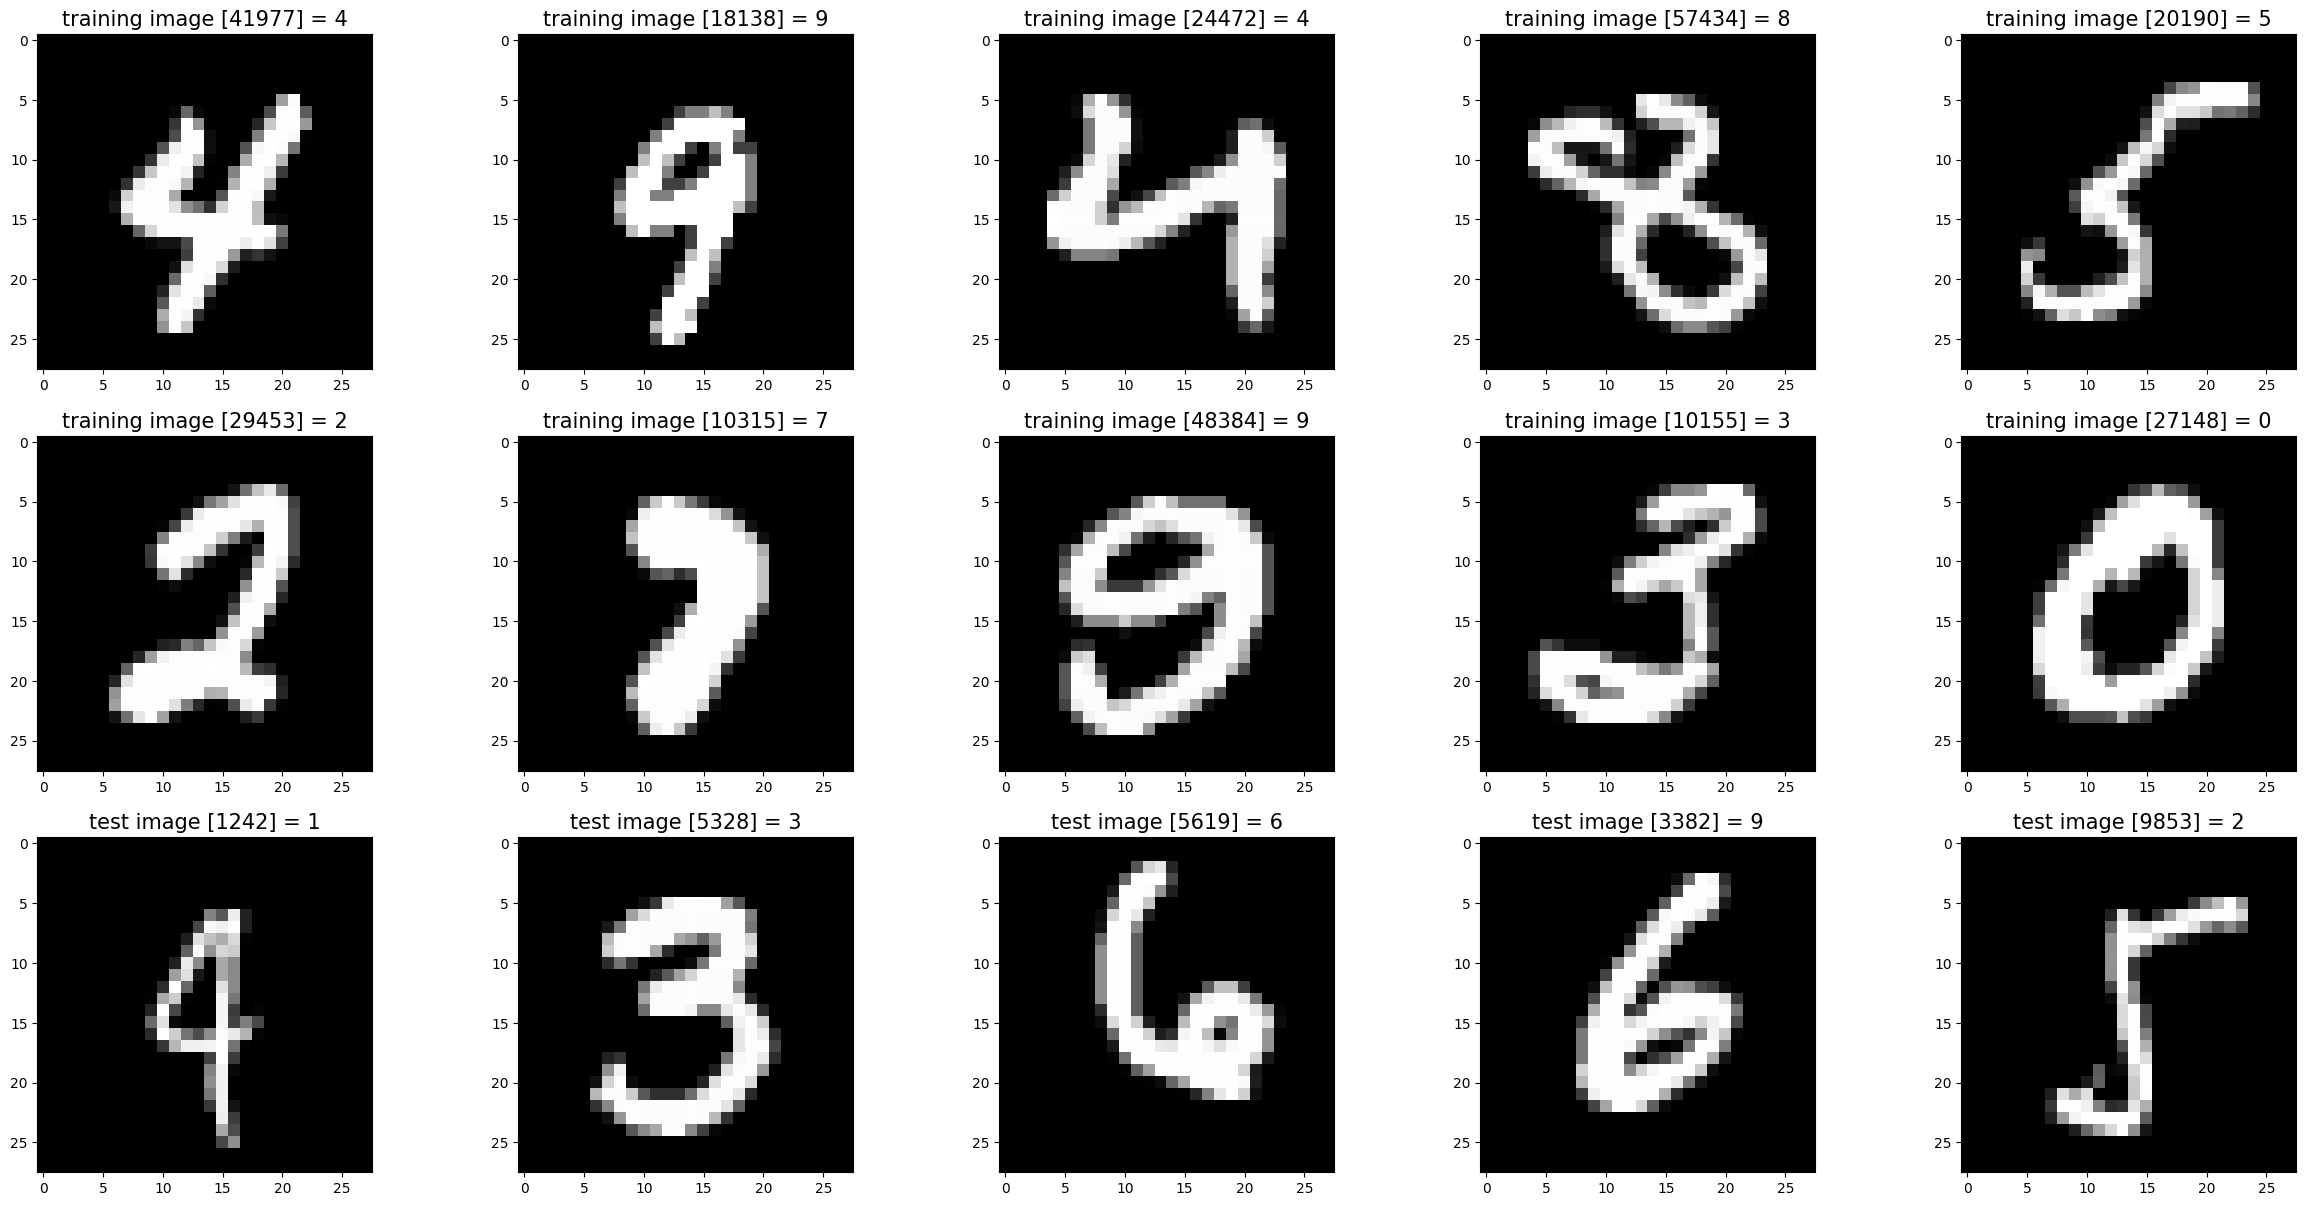

In [ ]:
# import random
# import matplotlib.pyplot as plt

# def show_images(images, title_texts):
#     cols = 5
#     rows = int(len(images)/cols) + 1
#     plt.figure(figsize=(30,20))
#     index = 1
#     for x in zip(images, title_texts):
#         image = x[0]
#         title_text = x[1]
#         plt.subplot(rows, cols, index)
#         plt.imshow(image, cmap=plt.cm.gray)
#         if (title_text != ''):
#             plt.title(title_text, fontsize = 15);
#         index += 1


# images_2_show = []
# titles_2_show = []
# for i in range(0, 10):
#     r = random.randint(1, 60000)
#     images_2_show.append(train_images[r])
#     titles_2_show.append('training image [' + str(r) + '] = ' + str(train_labels[r]))

# for i in range(0, 5):
#     r = random.randint(1, 10000)
#     images_2_show.append(test_images[r])
#     titles_2_show.append('test image [' + str(r) + '] = ' + str(train_labels[r]))

# show_images(images_2_show, titles_2_show)

One-hot encode the labels first.

In [ ]:
def one_hot(labels):
    return np.eye(10)[labels.reshape(-1)]

y_train = one_hot(y_train)
y_val = one_hot(y_val)
y_test = one_hot(y_test)

X_train = X_train.reshape([len(X_train),-1])
X_val = X_val.reshape([len(X_val),-1])
X_test = X_test.reshape([len(X_test),-1])

def custom_accuracy(scores, y_one_hot):
    preds = np.argmax(scores, axis=1)
    labels = np.argmax(y_one_hot, axis=1)
    return (preds == labels).mean()

In [ ]:
a = np.array([0, 0, 0, 2, 1])
b = np.array([0, 1, 0, 2, 1])
comparison = a == b
print(comparison.mean()*100)

80.0


In [ ]:
np.argmax(y_train[0])

np.int64(5)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 784)
(50000, 10)
(10000, 784)
(10000, 10)
(10000, 784)
(10000, 10)


In [ ]:
# Пример рукописного one-hot encoder
# labels_train_count = np.unique(np.array(train_labels)).shape[0]
# labels_train_flat = np.array(train_labels)

# def dense_to_one_hot(labels_dense, num_classes):
#   num_labels = labels_dense.shape[0]
#   index = np.arange(num_labels) * num_classes
#   labels_one_hot = np.zeros((num_labels, num_classes))
#   # flat - итератор по плоскому представлению массива
#   # заполняем 1 только индекс, соответствующий текущей метке
#   labels_one_hot.flat[index + labels_dense.ravel()] =  1
#   return labels_one_hot

# labels_one_hot_train = dense_to_one_hot(labels_train_flat, labels_train_count)

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions.
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5.

## Activation function comparison + BatchNormalization comparison

In [ ]:
def train_n_evaluate(
    net,
    X_train,
    y_train,
    X_val,
    y_val,
    optimizer,
    optimizer_config,
    optimizer_state
    ):
    """
    Принимает заданную архитектуру нейросети - net
    """

    loss_history_train = []
    loss_history_val = []
    accuracy_history_train = []
    accuracy_history_val = []

    for i in range(n_epoch):
        net.train()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):

            net.zeroGradParameters()

            # Forward
            predictions_train = net.forward(x_batch)
            loss_train = criterion.forward(predictions_train, y_batch)

            # Backward
            derivatives = criterion.backward(predictions_train, y_batch)
            net.backward(x_batch, derivatives)

            # Update weights
            optimizer(net.getParameters(),
                        net.getGradParameters(),
                        optimizer_config,
                        optimizer_state)

            loss_history_train.append(loss_train)

        # отключает Dropout, использует накопленные во время обучения статистики в batchnormalization)
        # отсутствие backward прохода на val датасете = аналог with torch.no_grad(), градиенты не рассчитываются
        net.evaluate()
        predictions_val = net.forward(X_val)
        loss_val = criterion.forward(predictions_val, y_val)
        loss_history_val.append(loss_val)

        accuracy_history_train.append(custom_accuracy(net.forward(X_train), y_train))
        accuracy_history_val.append(custom_accuracy(net.forward(X_val), y_val))

    # возвращает кортеж из 4 списков
    return loss_history_train, loss_history_val, accuracy_history_train, accuracy_history_val

In [ ]:
def plot(
    loss_history_train,
    loss_history_val,
    accuracy_history_train,
    accuracy_history_val
    ):
    """
    Для построения более простого графика для конкретной архитектуры
    """
    display.clear_output(wait=True)
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 2, 1)
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_train, 'b')

    plt.subplot(2, 2, 2)
    plt.title("Train accuracy")
    plt.xlabel("#epoch")
    plt.ylabel("accuracy")
    plt.plot(accuracy_history_train, 'b')

    plt.subplot(2, 2, 3)
    plt.title("Validation loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_val, 'b')

    plt.subplot(2, 2, 4)
    plt.title("Validation accuracy")
    plt.xlabel("#epoch")
    plt.ylabel("accuracy")
    plt.plot(accuracy_history_val, 'b')
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_comparison(results_dict, title_suffix="", use_log_scale=False):
    display.clear_output(wait=True)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Сравнение функций активации {title_suffix}', fontsize=16, y=1.02)

    colors = {
        'ReLU': 'blue',
        'ELU': 'green',
        'LeakyReLU': 'red',
        'SoftPlus': 'purple'
    }

    markers = {
        'ReLU': 'o',
        'ELU': 's',
        'LeakyReLU': '^',
        'SoftPlus': 'D'
    }

    ax = axes[0, 0]
    for act_name, results in results_dict.items():
        train_loss, _, _, _ = results
        ax.plot(train_loss, label=act_name,
                color=colors.get(act_name, 'gray'),
                marker=markers.get(act_name, 'o'),
                markersize=4, markevery=len(train_loss)//10)

    ax.set_title(f"Training Loss {title_suffix}")
    ax.set_xlabel("Iteration (batch number)")
    ax.set_ylabel("Loss")
    if use_log_scale:
        ax.set_yscale('log')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    for act_name, results in results_dict.items():
        _, _, train_acc, _ = results
        ax.plot(train_acc, label=act_name,
                color=colors.get(act_name, 'gray'),
                marker=markers.get(act_name, 'o'),
                markersize=6)

    ax.set_title(f"Train Accuracy {title_suffix}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    for act_name, results in results_dict.items():
        _, val_loss, _, _ = results
        ax.plot(val_loss, label=act_name,
                color=colors.get(act_name, 'gray'),
                marker=markers.get(act_name, 'o'),
                markersize=6)

    ax.set_title(f"Validation Loss {title_suffix}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    if use_log_scale:
        ax.set_yscale('log')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    for act_name, results in results_dict.items():
        _, _, _, val_acc = results
        ax.plot(val_acc, label=act_name,
                color=colors.get(act_name, 'gray'),
                marker=markers.get(act_name, 'o'),
                markersize=6)

    ax.set_title(f"Validation Accuracy {title_suffix}")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
def make_net(
    activation_func: SoftPlus(),
    batchnorm: bool = False
    ):
    net = Sequential()
    net.add(Linear(784, 128))
    if batchnorm:
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(128))
    net.add(activation_func)
    net.add(Linear(128, 10))
    net.add(LogSoftMax())

    criterion = ClassNLLCriterion()

    return net

In [ ]:
optimizers_config = {
    'adam_optimizer': {
        'optimizer_config': {
            'learning_rate': 3e-3,
            'beta1': 0.99,
            'beta2': 0.99,
            'epsilon': 1e-5
        },
        'optimizer_state': {}
    },
    'sgd_momentum': {
        'optimizer_config': {
            'learning_rate': 1e-1,
            'momentum': 0.9
        },
        'optimizer_state': {}
    }
}

# Использование
sgd_config = optimizers_config['sgd_momentum']['optimizer_config']
sgd_state = optimizers_config['sgd_momentum']['optimizer_state']

adam_config = optimizers_config['adam_optimizer']['optimizer_config']
adam_state = optimizers_config['adam_optimizer']['optimizer_state']

# Looping params
n_epoch = 30
batch_size = 1000

In [ ]:
%time

activations = {
    "ReLU": ReLU(),
    "ELU": ELU(),
    "LeakyReLU": LeakyReLU(),
    "SoftPlus": SoftPlus(),
}

results_no_bn = {}
results_with_bn = {}

for name, act in activations.items():
    # no batchnorm
    net = make_net(act, batchnorm=False)
    results_no_bn[name] = train_n_evaluate(
                            net, X_train, y_train, X_val,
                            y_val, sgd_momentum, sgd_config, sgd_state
    )


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


50it [00:01, 31.65it/s]
50it [00:03, 13.11it/s]
50it [00:01, 26.08it/s]
50it [00:01, 32.01it/s]
50it [00:01, 32.22it/s]
50it [00:01, 31.98it/s]
50it [00:01, 27.60it/s]
50it [00:03, 13.79it/s]
50it [00:01, 31.41it/s]
50it [00:01, 31.55it/s]
50it [00:01, 32.07it/s]
50it [00:01, 31.19it/s]
50it [00:03, 13.13it/s]
50it [00:01, 26.45it/s]
50it [00:01, 31.36it/s]
50it [00:01, 31.28it/s]
50it [00:01, 31.26it/s]
50it [00:02, 18.28it/s]
50it [00:03, 16.57it/s]
50it [00:01, 31.27it/s]
50it [00:01, 32.23it/s]
50it [00:01, 31.66it/s]
50it [00:02, 18.74it/s]
50it [00:03, 14.10it/s]
50it [00:01, 31.35it/s]
50it [00:01, 25.57it/s]
50it [00:01, 31.16it/s]
50it [00:01, 32.38it/s]
50it [00:04, 12.45it/s]
50it [00:01, 31.43it/s]
50it [00:01, 26.44it/s]
50it [00:02, 21.33it/s]
50it [00:03, 16.23it/s]
50it [00:04, 12.25it/s]
50it [00:01, 26.17it/s]
50it [00:01, 25.76it/s]
50it [00:02, 18.32it/s]
50it [00:03, 14.30it/s]
50it [00:01, 25.83it/s]
50it [00:01, 25.80it/s]
50it [00:04, 10.87it/s]
50it [00:01, 25.

In [ ]:
# Здесь я не передавала в train_n_evaluate() criterion, а он не прикреплялся к net. Поэтому перед каждым новым запуском train_n_evaluate() приходилось вызывать заново ячейку с созданием net
# Без этого кривые loss, accuracy выглядели безумно, loss рос, например
# Вероятно, можно просто передавать criterion заново при каждом вызове train_n_evaluate(), и это избавит от аналогичных проблем
# Будет проверено в pytorch implementation последнего пункта
for name, act in activations.items():
    # with batchnorm
    net_bn = make_net(act, batchnorm=True)
    results_with_bn[name] = train_n_evaluate(
                            net_bn, X_train, y_train, X_val,
                            y_val, sgd_momentum, sgd_config, sgd_state
    )

50it [00:02, 17.51it/s]
50it [00:02, 17.45it/s]
50it [00:01, 26.93it/s]
50it [00:01, 26.66it/s]
50it [00:01, 26.26it/s]
50it [00:04, 10.78it/s]
50it [00:01, 25.23it/s]
50it [00:01, 27.03it/s]
50it [00:02, 18.88it/s]
50it [00:04, 10.06it/s]
50it [00:01, 26.97it/s]
50it [00:01, 26.87it/s]
50it [00:01, 26.79it/s]
50it [00:02, 23.65it/s]
50it [00:03, 13.65it/s]
50it [00:01, 27.35it/s]
50it [00:01, 26.84it/s]
50it [00:01, 26.84it/s]
50it [00:03, 13.61it/s]
50it [00:02, 21.50it/s]
50it [00:01, 26.90it/s]
50it [00:01, 26.32it/s]
50it [00:01, 26.49it/s]
50it [00:04, 11.44it/s]
50it [00:01, 27.00it/s]
50it [00:02, 24.09it/s]
50it [00:01, 27.21it/s]
50it [00:03, 15.05it/s]
50it [00:02, 19.44it/s]
50it [00:01, 27.37it/s]
50it [00:02, 22.29it/s]
50it [00:02, 22.63it/s]
50it [00:04, 10.31it/s]
50it [00:02, 17.69it/s]
50it [00:03, 13.55it/s]
50it [00:03, 15.52it/s]
50it [00:02, 22.67it/s]
50it [00:02, 22.13it/s]
50it [00:04, 10.29it/s]
50it [00:02, 22.42it/s]
50it [00:02, 22.85it/s]
50it [00:02, 22.

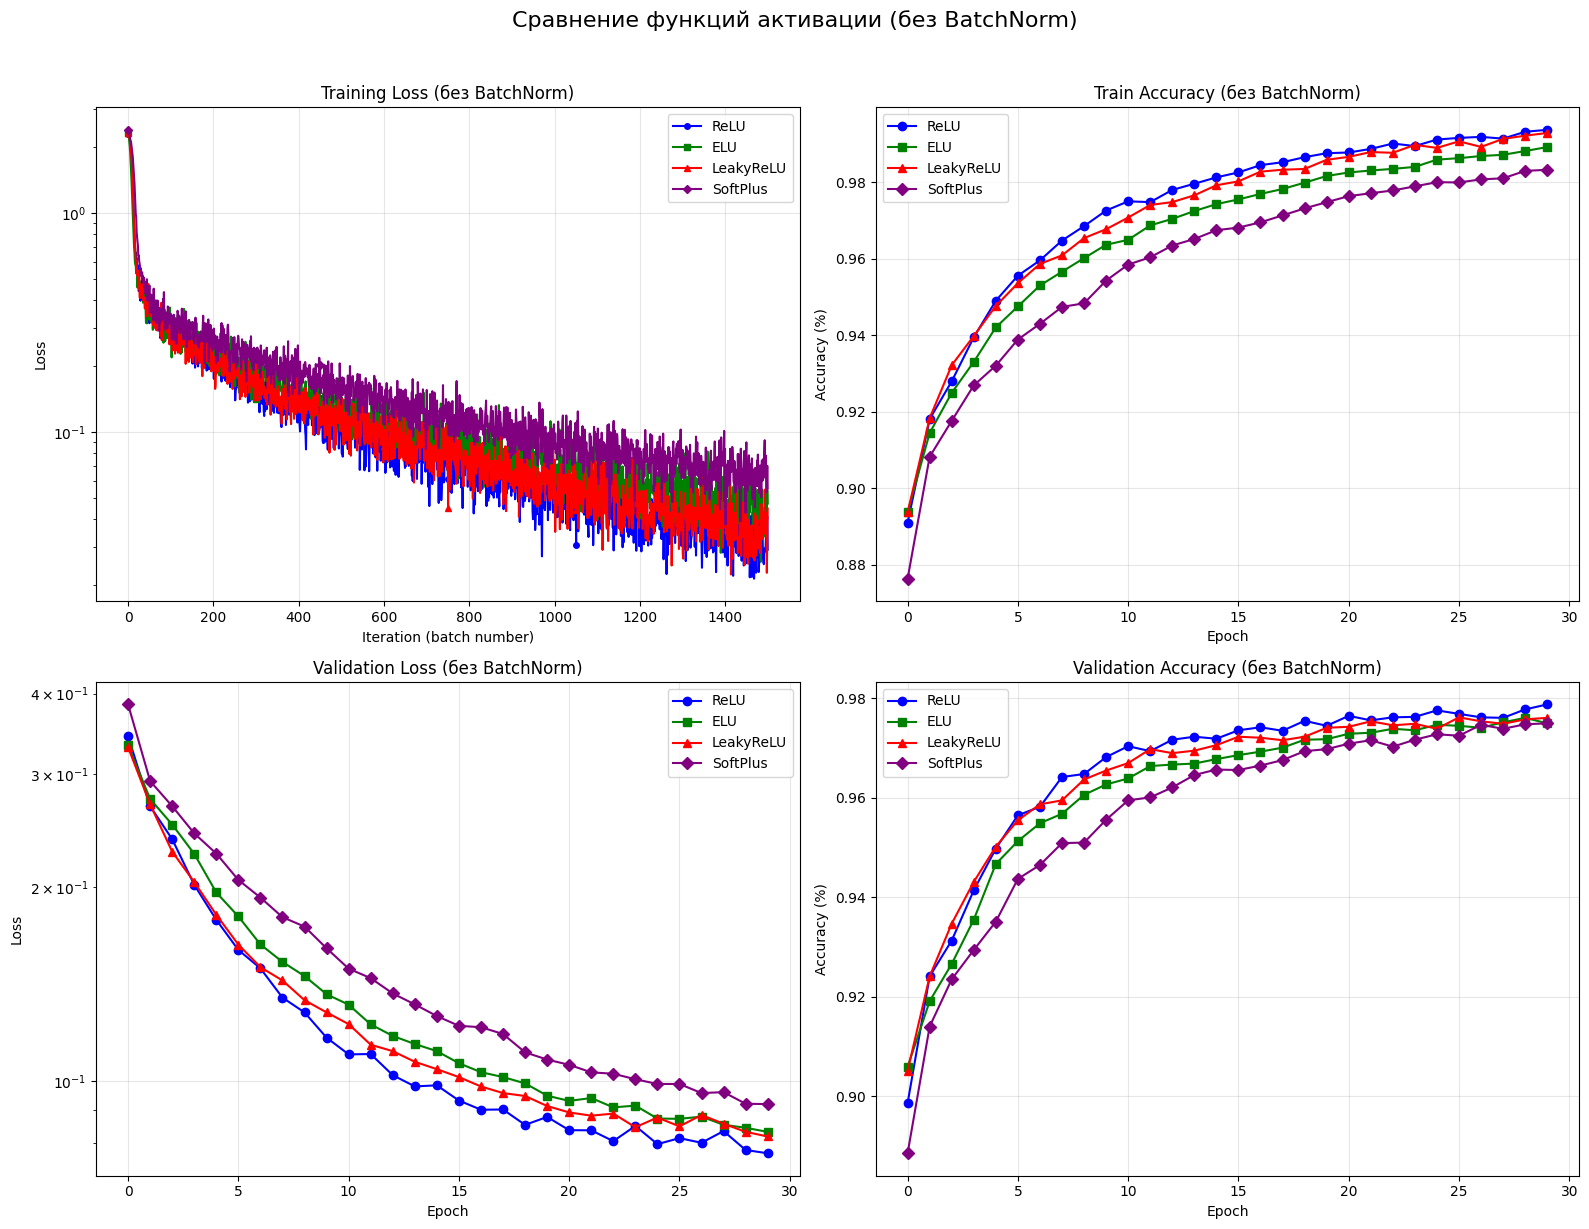

In [ ]:
plot_comparison(results_no_bn, title_suffix="(без BatchNorm)", use_log_scale=True)

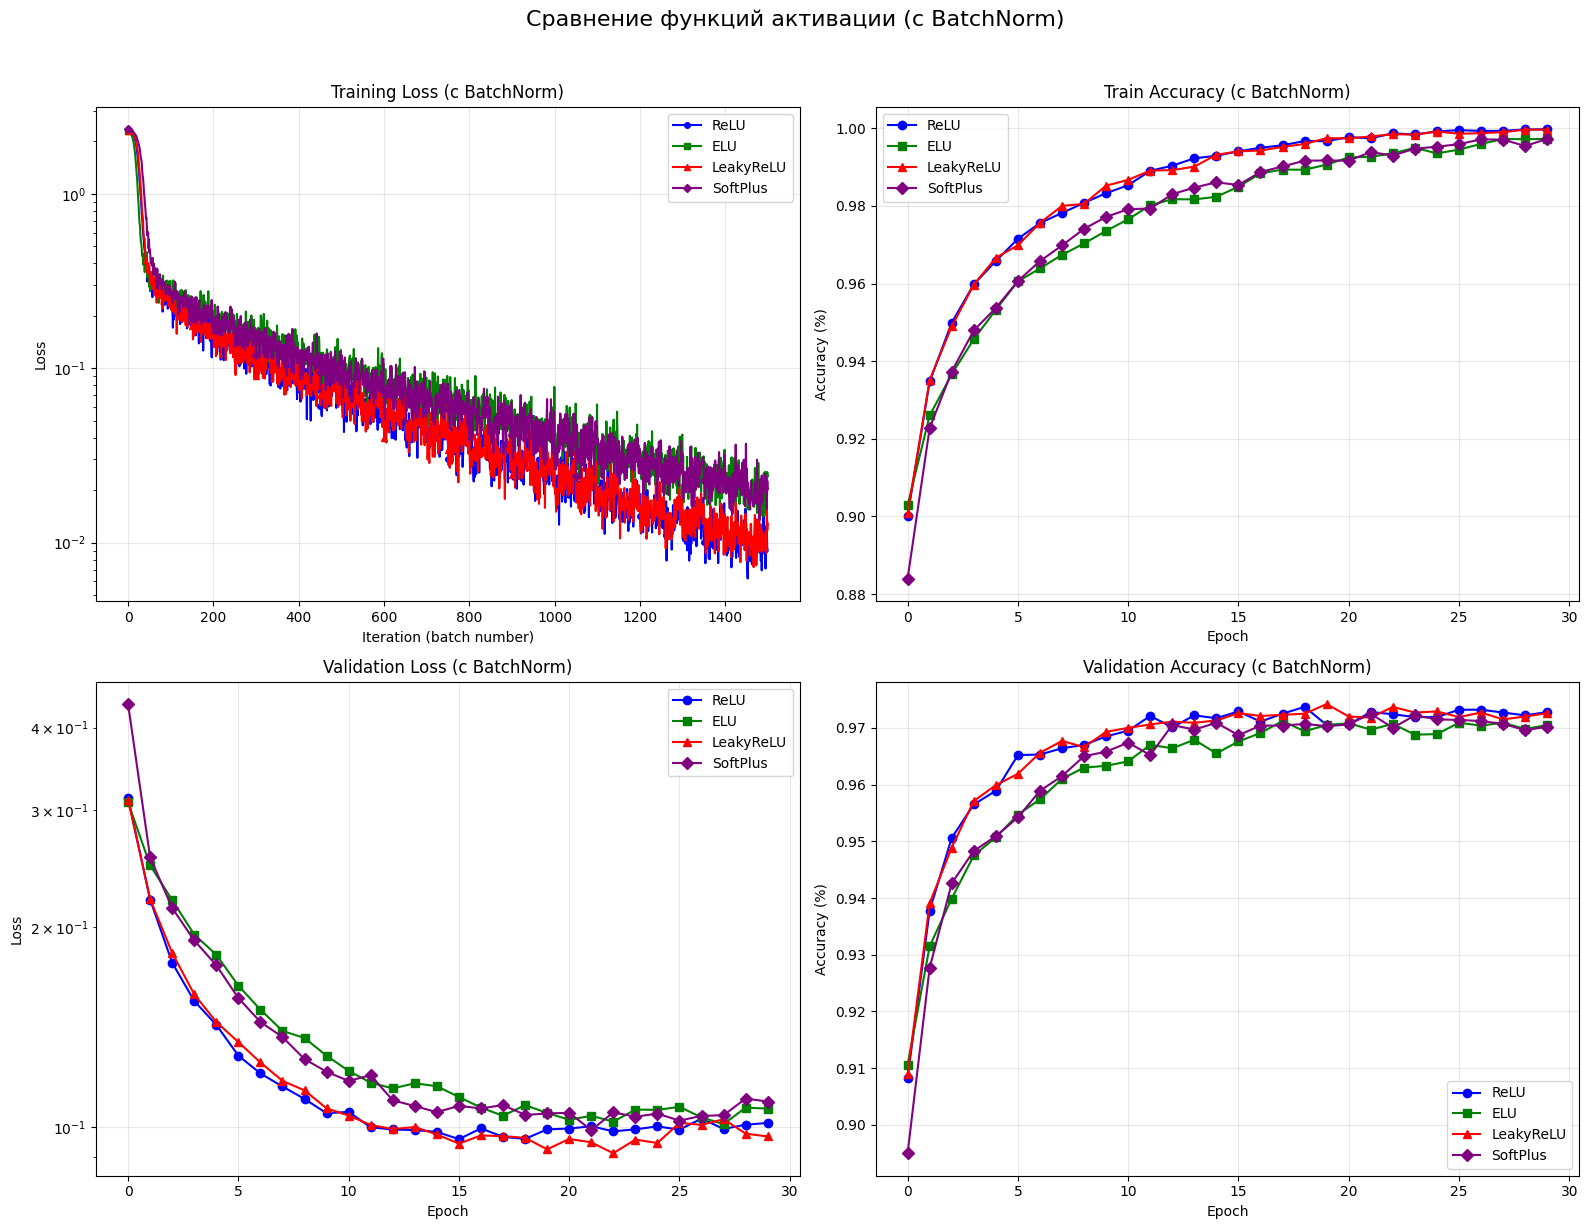

In [ ]:
plot_comparison(results_with_bn, title_suffix="(с BatchNorm)", use_log_scale=True)

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Выводы по BatchNormalization**

1. Результаты экспериментов с выбранной архитектурой нейросети говорят о том, что обучение с использованием BatchNormalization проходят более стабильно (линии loss и accuracy для разных функций активации ближе друг к другу)

2. Более высокий, однако accuracy на валидационном наборе удалось достичь без использования BatchNormalization в данном конкретном эксперименте.

**Выводы по функциям активации**

Наилучший результат у ReLU. К этому же уровню приближается только LeakyReLU при применении BatchNormalization

## Sgd Momentum vs Adam

In [ ]:
net = Sequential()
net.add(Linear(784, 128))
net.add(ReLU())
net.add(Linear(128, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax



In [ ]:
n_epoch = 30
batch_size = 1000

train_eval_results_sgd = train_n_evaluate(net, X_train, y_train, X_val,
                                      y_val, sgd_momentum, sgd_config, sgd_state)

In [ ]:
train_eval_results_adam = train_n_evaluate(net, X_train, y_train, X_val,
                                      y_val, adam_optimizer, adam_config, adam_state)

In [ ]:
def plot_optimizers_comparison(sgd_results, adam_results, title_suffix=""):
    display.clear_output(wait=True)

    sgd_train_loss, sgd_val_loss, sgd_train_acc, sgd_val_acc = sgd_results
    adam_train_loss, adam_val_loss, adam_train_acc, adam_val_acc = adam_results

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'Сравнение SGD и Adam {title_suffix}', fontsize=16, y=1.02)

    ax = axes[0, 0]
    ax.plot(sgd_train_loss, 'b-', linewidth=1.5, alpha=0.7, label='SGD+Momentum')
    ax.plot(adam_train_loss, 'r-', linewidth=1.5, alpha=0.7, label='Adam')
    ax.set_title("Training Loss")
    ax.set_xlabel("Iteration (batch number)")
    ax.set_ylabel("Loss")
    ax.set_yscale('log')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    ax = axes[0, 1]
    ax.plot(sgd_train_acc, 'b-o', linewidth=2, markersize=4, label='SGD+Momentum')
    ax.plot(adam_train_acc, 'r-s', linewidth=2, markersize=4, label='Adam')
    ax.set_title("Train Accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 0]
    ax.plot(sgd_val_loss, 'b-o', linewidth=2, markersize=6, label='SGD+Momentum')
    ax.plot(adam_val_loss, 'r-s', linewidth=2, markersize=6, label='Adam')
    ax.set_title("Validation Loss")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.set_yscale('log')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    ax = axes[1, 1]
    ax.plot(sgd_val_acc, 'b-o', linewidth=2, markersize=6, label='SGD+Momentum')
    ax.plot(adam_val_acc, 'r-s', linewidth=2, markersize=6, label='Adam')
    ax.set_title("Validation Accuracy")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy (%)")
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

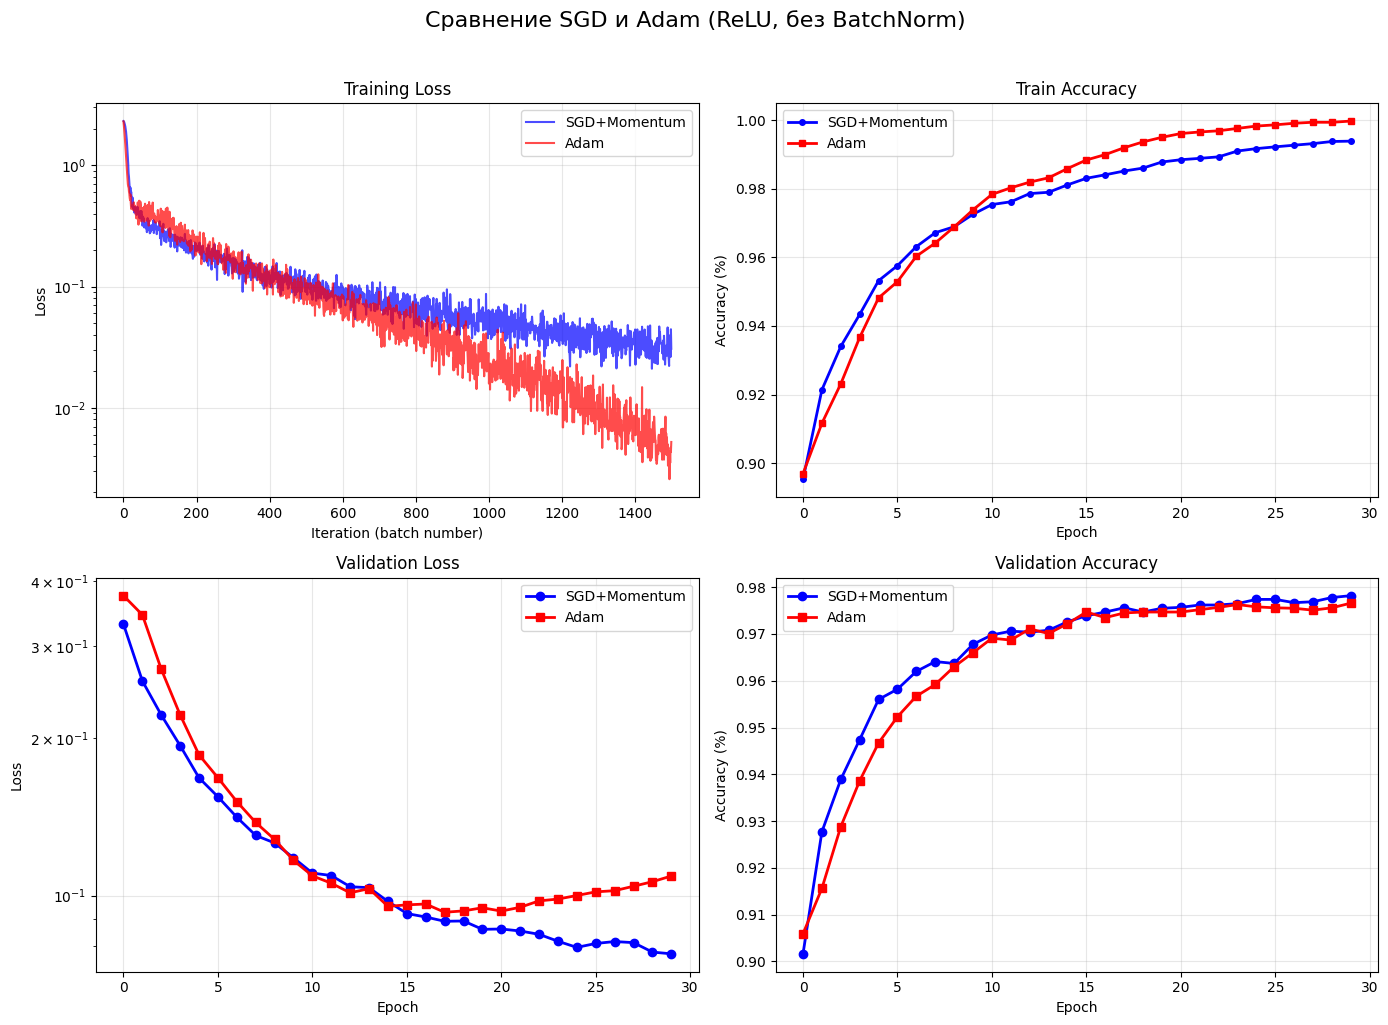

In [ ]:
plot_optimizers_comparison(
    sgd_results=train_eval_results_sgd,
    adam_results=train_eval_results_adam,
    title_suffix="(ReLU, без BatchNorm)"
)

**Вывод**
1. При подобранной архитектуре лучший результат по accuracy на валидайионном датасете показывает SDG with Momentum.
2. Однако согласно литературным данным Adam также является надежным и широко распространенным подходом.

## Creating more complex net

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [ ]:
# ВАЖНО: научиться затирать состояние net для следующих экспериментов
net = Sequential()
net.add(Linear(784, 500))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(500))
net.add(ReLU())
net.add(Dropout(0.3))
net.add(Linear(500, 200))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(200))
net.add(ReLU())
net.add(Dropout(0.3))
net.add(Linear(200, 10))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

Linear 784 -> 500
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 500 -> 200
BatchNormalization
ChannelwiseScaling
ReLU
Dropout
Linear 200 -> 10
LogSoftMax



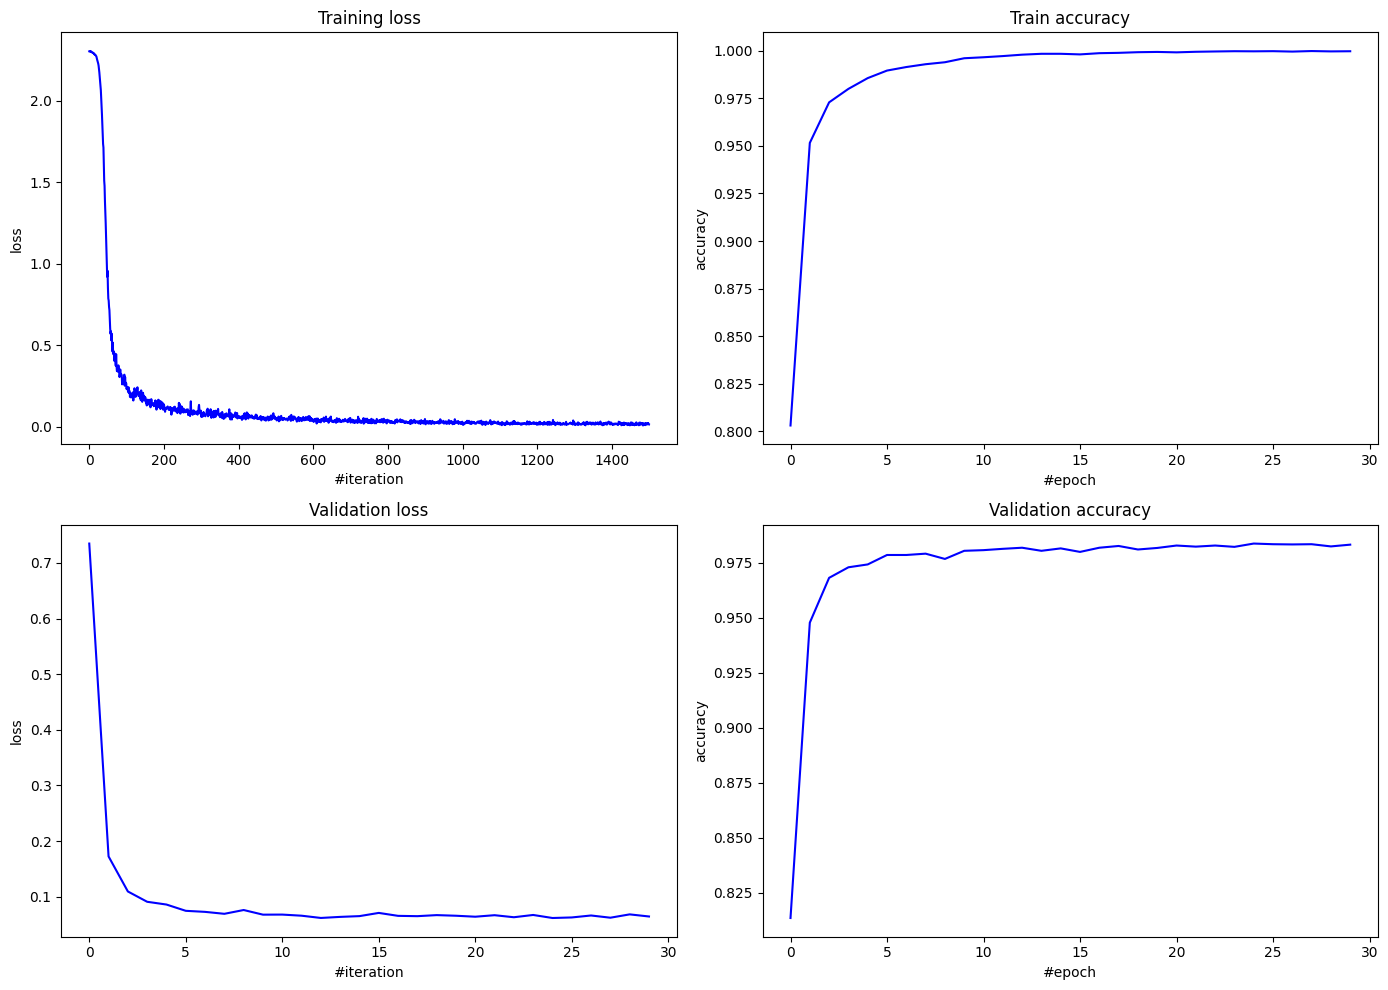

In [ ]:
# Вызов на тестовом датасете, чтобы получить test accuracy
train_eval_results = train_n_evaluate(net, X_train, y_train, X_test,
                                      y_test, sgd_momentum, sgd_config, sgd_state)

plot(*train_eval_results)

Print here your accuracy on test set. It should be around 90%.

In [ ]:
print('test accuracy:', accuracy_history_val[-1])

test accuracy: 0.9425


### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__

In [ ]:
# Your beautiful code here.
import torch
from torch import nn

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [ ]:
import mnist

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

In [ ]:
X_train.shape
X_val.shape

(10000, 28, 28)

In [ ]:
# В этой реализации one-hot encoding только мешает
X_train_tensor = torch.from_numpy(X_train).reshape(-1, 784)
X_val_tensor = torch.from_numpy(X_val).reshape(-1, 784)
X_test_tensor = torch.from_numpy(X_test).reshape(-1, 784)

y_train_tensor = torch.from_numpy(y_train)
y_val_tensor = torch.from_numpy(y_val)
y_test_tensor = torch.from_numpy(y_test)
print(type(X_train_tensor))

<class 'torch.Tensor'>


In [ ]:
X_train_tensor.shape

torch.Size([50000, 784])

In [ ]:
# the same handwritten net
# net = Sequential()
# net.add(Linear(784, 500))
# net.add(BatchNormalization())
# net.add(ChannelwiseScaling(500))
# net.add(ReLU())
# net.add(Dropout(0.3))
# net.add(Linear(500, 200))
# net.add(BatchNormalization())
# net.add(ChannelwiseScaling(200))
# net.add(ReLU())
# net.add(Dropout(0.3))
# net.add(Linear(200, 10))
# net.add(LogSoftMax())

# criterion = ClassNLLCriterion()

In [ ]:
model = nn.Sequential(
    nn.Linear(784, 500),
    nn.BatchNorm1d(500),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(500, 200),
    nn.BatchNorm1d(200),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(200, 10),
    nn.LogSoftmax()
)

# loss_func is the same as criterion
loss_func = nn.CrossEntropyLoss()
# loss_func = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-3)

model.to(device, torch.float64)

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Linear(in_features=500, out_features=200, bias=True)
  (5): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): Dropout(p=0.3, inplace=False)
  (8): Linear(in_features=200, out_features=10, bias=True)
  (9): LogSoftmax(dim=None)
)

In [ ]:
def train_n_evaluate_torch(
    model,
    X_train,
    y_train,
    X_val,
    y_val,
    loss_func,
    optimizer,
    n_epoch
    ):
    """
    Измененная по сравнению с train_n_evaluate() версия.
    1) Добавлен перенос батчей на gpu. Для этого подаются torch тензоры, а не numpy массивы
    2) Оставлены закомментированные аналогичные по смыслу куски кода для использования кастомной, а не torch нейросети
    3) Добавлена loss_func (criterion) в аргументы функции
    """

    loss_history_train = []
    loss_history_val = []
    accuracy_history_train = []
    accuracy_history_val = []

    for i in range(n_epoch):

        epoch_train_loss = []
        epoch_train_acc = []
        epoch_val_loss = []
        epoch_val_acc = []

        # net.train() ---
        model.train()
        for x_batch, y_batch in get_batches((X_train, y_train), batch_size):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # net.zeroGradParameters() ---
            optimizer.zero_grad()
            # Forward
            # predictions_train = net.forward(x_batch) ---
            # loss_train = criterion.forward(predictions_train, y_batch) ---
            predictions = model(x_batch)
            loss = loss_func(predictions, y_batch)
            # Backward
            # derivatives = criterion.backward(predictions_train, y_batch) ----
            # net.backward(x_batch, derivatives) ---
            loss.backward()
            # Update weights
            # optimizer(net.getParameters(), ---
            #             net.getGradParameters(),
            #             optimizer_config,
            #             optimizer_state)
            optimizer.step()
            # Сохраним, чтобы далее усреднить loss по батчам в пределах эпохи (не будет такого дергания)
            epoch_train_loss.append(loss.item())
            # epoch_train_acc.append(custom_accuracy(model(x_batch), y_train))  # было в прошлой реализации
            epoch_train_acc.append((predictions.argmax(dim=1) == y_batch).float().mean().item())

        # отключает Dropout, использует накопленные во время обучения статистики в batchnormalization)
        model.eval()
        # аналог отсутствия backward
        with torch.no_grad():
            for x_batch, y_batch in get_batches((X_val, y_val), batch_size):
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)

                # predictions_val = net.forward(X_val) ---
                # loss_val = criterion.forward(predictions_val, y_val) ---
                predictions = model(x_batch)
                loss = loss_func(predictions, y_batch)

                epoch_val_loss.append(loss.item())
                # predictions.argmax(dim=1) in torch is the same as np.argmax(predictions, axis=1) in numpy
                epoch_val_acc.append((predictions.argmax(dim=1) == y_batch).float().mean().item())

        # Усредняем результаты по батчам в рамках каждой эпохи
        loss_history_train.append(np.mean(epoch_train_loss))
        loss_history_val.append(np.mean(epoch_val_loss))
        accuracy_history_train.append(np.mean(epoch_train_acc))
        accuracy_history_val.append(np.mean(epoch_val_acc))

        print(f"train loss: {loss_history_train[-1]:.6f}")
        print(f"validation loss: {loss_history_val[-1]:.6f}")
        print(f"train accuracy: {accuracy_history_train[-1]:.3f}")
        print(f"validation accuracy: {accuracy_history_val[-1]:.3f}")

    return loss_history_train, loss_history_val, accuracy_history_train, accuracy_history_val

In [ ]:
n_epochs = 30
batch_size = 1000

train_loss, val_loss, train_accuracy, val_accuracy = train_n_evaluate_torch(model, X_train_tensor, y_train_tensor,
                                                                                            X_val_tensor, y_val_tensor, loss_func, optimizer, n_epochs)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


train loss: 0.369483
validation loss: 0.141337
train accuracy: 0.959
validation accuracy: 0.959
train loss: 0.137879
validation loss: 0.098650
train accuracy: 0.971
validation accuracy: 0.971
train loss: 0.100896
validation loss: 0.078842
train accuracy: 0.977
validation accuracy: 0.977
train loss: 0.076048
validation loss: 0.079858
train accuracy: 0.976
validation accuracy: 0.976
train loss: 0.065668
validation loss: 0.074368
train accuracy: 0.978
validation accuracy: 0.978
train loss: 0.058602
validation loss: 0.075412
train accuracy: 0.978
validation accuracy: 0.978
train loss: 0.044872
validation loss: 0.069396
train accuracy: 0.980
validation accuracy: 0.980
train loss: 0.039988
validation loss: 0.064468
train accuracy: 0.983
validation accuracy: 0.983
train loss: 0.035206
validation loss: 0.065009
train accuracy: 0.982
validation accuracy: 0.982
train loss: 0.032055
validation loss: 0.066993
train accuracy: 0.981
validation accuracy: 0.981
train loss: 0.028913
validation loss: 0.

In [ ]:
# Стоит потренироваться с early stopping, ....

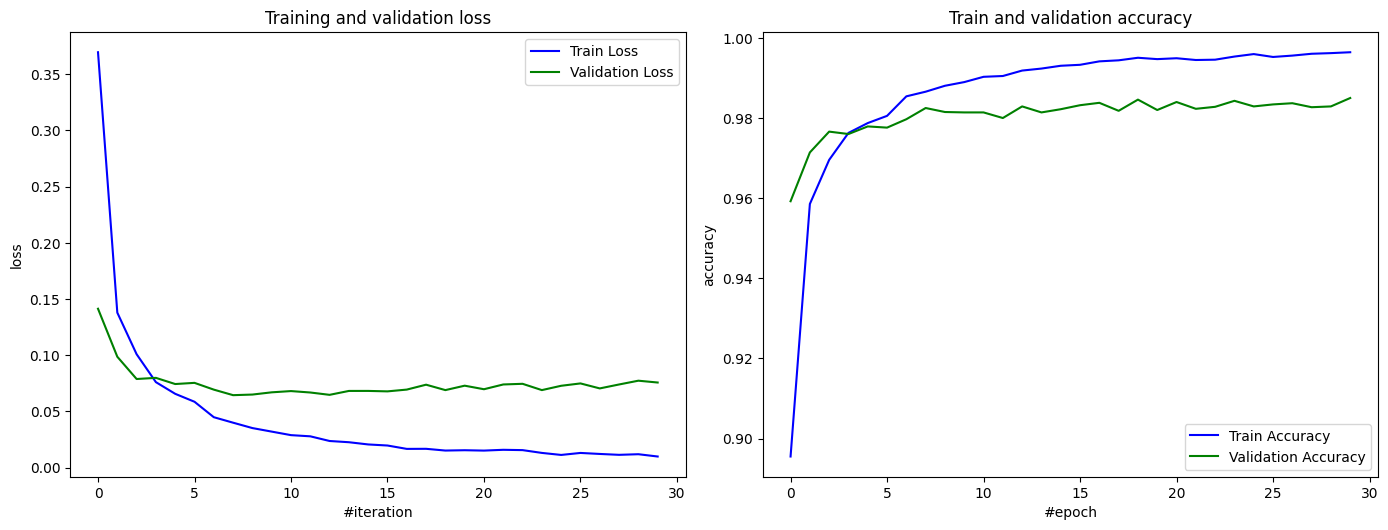

In [ ]:
display.clear_output(wait=True)
plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.title("Training and validation loss")
plt.xlabel("#iteration")
plt.ylabel("loss")
plt.plot(train_loss, 'b', label='Train Loss')
plt.plot(val_loss, 'g', label = 'Validation Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.title("Train and validation accuracy")
plt.xlabel("#epoch")
plt.ylabel("accuracy")
plt.plot(train_accuracy, 'b', label = 'Train Accuracy')
plt.plot(val_accuracy, 'g', label = 'Validation Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

In [ ]:
def test(
    model,
    X_test,
    y_test,
    loss_func,
    batch_size=1000
    ):

    model.eval()

    loss_test = []
    acc_test = []

    with torch.no_grad():
        for x_batch, y_batch in get_batches((X_test, y_test), batch_size):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model(x_batch)

            loss = loss_func(predictions, y_batch)
            loss_test.append(loss.item())

            batch_accuracy = (predictions.argmax(dim=1) == y_batch).float().mean().item()
            acc_test.append(batch_accuracy)

    avg_test_loss = np.mean(loss_test)
    avg_test_accuracy = np.mean(acc_test)
    print(f"Test Loss: {avg_test_loss:.6f}")
    print(f"Test Accuracy: {avg_test_accuracy:.3f}")
    return avg_test_loss, avg_test_accuracy

In [ ]:
test_loss, test_accuracy = test(model, X_test_tensor, y_test_tensor,
                                loss_func=loss_func, batch_size=1000)
print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1775: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Test Loss: 0.067539
Test Accuracy: 0.984
Test loss: 0.0675, Test accuracy: 0.9840


**Вывод**
1. Переобучение незначительно, т.к. accuracy на test/val не кардинально ниже, чем на train.
2. Аналогично, loss на val/test не значительно выше, чем на train.